# 개요

## 학습목표
- 학습용 데이터 없이 모델을 학습할 수 있는 방법 설명
- CIFAR-10 을 이용, 동물 사진을 분류하는 모델

## 핵심 용어
- 모델 경량화 : 가중치 개수가 많은 교사모델의 출력과, 가중치 개수가 적은 학생 모델의 출력이 비슷해 지도록 학습 하는 것
- 지식증류 알고리즘 : 가중치가 많은 교사 모델을 이용, 가중치가 적은 학생 모델을 학습 시키는 것
- 모델 경량화와 GAN을 이용하면 데이터 없이 학생 모델 학습 가능
- 데이터 없이 학습시엔, 생성자 보다 학생 모델을 더 많이 학습
- L1 손실 : 두 값의 절대값 차이를 의미, L2 손실은 MSE 처럼 두 값의 차이를 제곱합

# 이해하기

## 모델 경량화

- 고성능의 딥러닝 모델일 수록 뉴런, 층 수 등이 늘어 남
- 모바일 환경이나 임베딩 기기 환경에서는 이런 모델들을 사용하기 어려움
- 큰 모델을 가볍게 만드는 경량화 기업이 필요
- 지식증류
    - 모델 경량화 기법의 일종
    - 더 많은 가중치의 모델(교사 모델)을 이용, 적은 가중치를 갖는 모델(학생 모델) 학습 하는 기법

<img src='./figs/15_01.png' width=800>

- 1. 교사 모델과 학생 모델은 같은 입력을 갖음
- 2. 두 모델은 서로 다른 예측값을 출력
    - 교사 모델과 학생 모델의 예측값의 차이를 '소프트 라벨' 이라고 함
    - '소프트 라벨'로 학습을 한 학생 모델은 교사 모델의 예측값을 흉내 냄
    - 그러나 교사 모델이 항상 맞다고는 할 수 없어, 정답으로 다시 학습을 해야 함
- 3. 정답과 학생 모델의 예측값의 차이를 '하드 라벨'이라고 함
    - 하드 라벨은, 학생 모델의 학습이 올바른 방향으로 가도록 함 

## GAN을 이용한 경량화

<img src='./figs/15_02.png' width=800>

- 데이터 셋을 전혀 모르는 상황에서 학습되기 때문에 하드 라벨 이용 불가
- 학생 모델은 교사 모델의 동작을 흉내내도록 학습 (소프트 라벨만 사용)
- 학생 모델 학습 시, 생성자의 가중치는 불변
- 생성자는 교사 모델과 학생 모델의 차이가 벌어질 수 있도록 학습
    - 학생 모델에게 더 어려운 학습용 데이터를 만들어 낼 수 있도록 해야 하기 때문
    - 교사 모델과 학생 모델의 차이를 구분하는 감별자로, 생성자 학습


<img src='./figs/15_03.png' width=800>

# 교사 모델 학습하기
- 교사 모델은 resnet34과 CIFAR-10 데이터셋 사용 학습

In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torchvision.transforms import Normalize
from torch.utils.data.dataloader import DataLoader
from torchvision.models.resnet import resnet34, resnet18

from torch.optim.adam import Adam

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 학습할 때 이용하는 전처리 정의
transforms = Compose([
    RandomCrop((32, 32), padding=4), 
    RandomHorizontalFlip(p=0.5), # y축 대칭
    ToTensor(),
    Normalize(mean=(0.4914, 0.822, 0.4465),
             std=(0.247, 0.243, 0.261))    
])

In [3]:
train_data = CIFAR10(root='/home/restful3/datasets/torch/',
                       train=True, download=True, transform=transforms)
test_data = CIFAR10(root='/home/restful3/datasets/torch/',
                       train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True
)

# 검증용 데이터 준비
test_loader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False
)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
# 교사 모델 정의, Pretrained 를 사용하지 않는 경우
teacher = resnet34(pretrained=False, num_classes=10)
# # 모델을 사용할 디바이스로 이동
teacher.to(device)

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Pretrained 를 사용하는 경우
# teacher = resnet34(pretrained=False)
# # 새로운 클래스 개수
# num_classes = 10

# # 모델의 fc 레이어를 새로운 클래스 개수에 맞게 변경
# teacher.fc = nn.Linear(in_features=teacher.fc.in_features, out_features=num_classes)



# # 모델의 fc 레이어 파라미터만 학습 가능하도록 설정
# for name, param in teacher.named_parameters():
#     if name.startswith('fc'):
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

In [8]:
lr = 1e-5
optim = Adam(teacher.parameters(), lr=lr)

- 교사 모델 학습 루프 정의

In [13]:
# 학습 루프
for epoch in range(200):
    iterator = tqdm(train_loader)
    for data, label in iterator:
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        
        preds = teacher(data)
        loss = nn.CrossEntropyLoss()(preds, label)
        loss.backward()
        
        optim.step()
        
        iterator.set_description(f'epoch : {epoch+1}, loss : {loss.item()} ')

# 교사 모델 가중치 저장        
torch.save(teacher.state_dict(), './models/teacher.pth')        

epoch : 1, loss : 0.27944424748420715 : 100%|█| 1563/1563 [00:39<00:00, 39.75it/
epoch : 2, loss : 0.5613102912902832 : 100%|█| 1563/1563 [00:37<00:00, 41.37it/s
epoch : 3, loss : 0.3663482964038849 : 100%|█| 1563/1563 [00:35<00:00, 43.42it/s
epoch : 4, loss : 0.2970852255821228 : 100%|█| 1563/1563 [00:35<00:00, 43.67it/s
epoch : 5, loss : 0.4349748194217682 : 100%|█| 1563/1563 [00:36<00:00, 42.50it/s
epoch : 6, loss : 0.44562119245529175 : 100%|█| 1563/1563 [00:38<00:00, 41.12it/
epoch : 7, loss : 0.30879324674606323 : 100%|█| 1563/1563 [00:39<00:00, 39.73it/
epoch : 8, loss : 0.404263436794281 : 100%|█| 1563/1563 [00:38<00:00, 40.55it/s]
epoch : 9, loss : 0.7797971367835999 : 100%|█| 1563/1563 [00:38<00:00, 40.29it/s
epoch : 10, loss : 0.6153092384338379 : 100%|█| 1563/1563 [00:38<00:00, 40.45it/
epoch : 11, loss : 0.6239849328994751 : 100%|█| 1563/1563 [00:38<00:00, 40.40it/
epoch : 12, loss : 0.6754651069641113 : 100%|█| 1563/1563 [00:38<00:00, 40.58it/
epoch : 13, loss : 0.4894762

- 교사 모델 성능 확인

In [14]:
# 교사 모델의 가중치 불러오기
teacher.load_state_dict(torch.load('./models/teacher.pth', map_location=device))

num_corr = 0

# 교사 모델 성능 검증
with torch.no_grad():
    for data, label in tqdm(test_loader):
        data, label = data.to(device), label.to(device)
        
        output = teacher(data)
        preds = output.data.max(1)[1]
        corr = preds.eq(label).sum().item()
        num_corr += corr
        
    print(f'Acc : {num_corr/len(test_data)}')

100%|████████████████████████████████████████| 313/313 [00:03<00:00, 103.57it/s]

Acc : 0.7346


# GAN 생성자 정의하기
- GAN 생성자
    - 학생 모델을 학습할 때 사용할 이미지를 만듦
    - 중요한 점 : 
        - 학생 모델과 생성자의 학습 속도에 차이가 나면 안된다.
        - ResNet의 학습 속도가 GAN의 생성자에 비해 너무 빨라 학습이 되지 않는다.
        - 생성자는 학생 모델 학습에 필요한 이미지를 제대로 만들어 낼 수 없다.
        - 학생 모델의 학습 방향이 이상해 진다.
    - 따라서 GAN이 아닌, 합성곱층을 이용한 간단한 생성자 모델을 만든다.

<img src='./figs/15_04.png' width=800>

- 1. MLP 층과 배치 정규화층을 거친 입력은 128 채널, 8x8 이미지가 된다.
- 2. 합성곱과 업샘플링
    - 업샘플링 : interpolate() 메서드 이용
        - 가중치를 사용하지 않고 이미지의 해상도를 scale_factor 만큼 키움 
        - 2배 만큼 키우려면 scale_factor를 2로 설정
- 3. 합성곱층
    - 이미지의 픽셀값을 나타내는 출력층, 활성화층이 없다.
    - 활성함수를 통하게 되면 픽셀값의 변화가 생겨 정보 손실이 되기 때문

In [9]:
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, dims=256, channels=3):
        super(Generator, self).__init__()
        
        # 256 차원 벡터를 입력 받아 128 채널 8x8 이미지 생성
        self.l1 = nn.Sequential(
            nn.Linear(dims, 128*8*8)
        )
        
        self.conv_blocks0 = nn.Sequential(
            nn.BatchNorm2d(128)
        )
        
        self.conv_blocks1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2) # 활성화 함수
        )
        
        self.conv_blocks2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(channels, affine=False)# 배치 정규화
        )
        
    def forward(self, z):
        # 256 차원 벡터를 입력 받아 128 채널 8x8 이미지 생성
        out = self.l1(z.view(z.shape[0], -1))
        out = out.view(out.shape[0], -1, 8, 8)
        
        out = self.conv_blocks0(out)
        # 이미지를 두배 늘려 줌
        out = nn.functional.interpolate(out, scale_factor=2)
        out = self.conv_blocks1(out)
        out = nn.functional.interpolate(out, scale_factor=2)
        out = self.conv_blocks2(out)        
        
        return out

# 학생 모델과 생성자 학습하기

- 학습 순서
    - 교사 모델 -> 생성자 -> 학생 모델

<img src='./figs/15_05.png' width=800>

In [10]:
from torch.optim.adam import Adam
from torch.optim.sgd import SGD

# 교사 모델 불러오기
teacher = resnet34(pretrained=False, num_classes=10)
teacher.load_state_dict(torch.load('./models/teacher.pth', map_location=device))
teacher.to(device)
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# 학생 모델 정의
student = resnet18(pretrained=False, num_classes=10)
student.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# 생성자 정의
generator = Generator()
generator.to(device)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=256, out_features=8192, bias=True)
  )
  (conv_blocks0): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_blocks1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_blocks2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
)

- 생성자와 학생 모델의 최적화 알고리즘
    - 생성자는 수렴 속도가 빠른 adam
    - 학생 모델은 오버 피팅을 피하기 유리한 SGD
        - 1. **미니 배치 학습**: SGD는 전체 데이터셋 대신 작은 미니 배치를 사용하여 모델을 업데이트합니다. 이렇게 하면 각 반복(iteration)에서 모델이 전체 데이터셋을 기억하거나 과도하게 학습하는 것을 방지할 수 있습니다. 큰 데이터셋에서는 미니 배치 학습이 일반화(generalization)에 도움을 줄 수 있습니다.

        - 2. **노이즈 추가**: SGD는 확률적인 요소를 가지고 있기 때문에 학습 동안에 노이즈를 추가할 수 있습니다. 이러한 노이즈는 모델이 데이터에 과도하게 적합(fit)되는 것을 방지하고, 일반화 능력을 향상시킬 수 있습니다.

        - 3. **학습률 스케줄링**: SGD에서는 학습률(learning rate)을 조절할 수 있습니다. 학습률을 조절함으로써 모델이 수렴할 때 학습률을 줄이거나 증가시켜 오버피팅을 방지할 수 있습니다.
    - 생성자가 만들어내는 이미지는 원래의 데이터셋에 없음, 수렴이 빠른 adam으로 학생 모델을 학습하면 생성자의 이미지에 과적합 할 가능성 있음
    - SGD는 수렴 속도가 느려, 학생 모델에게 다양한 이미지를 제공하기 어려워, 생성자에는 맞지 않음.

In [13]:
# 생성자는 Adam으로, 학생 모델은 SGD를 이용해 학습
G_optim = Adam(generator.parameters(), lr=1e-3)
S_optim = SGD(student.parameters(), lr=0.1, weight_decay=5e-4, momentum=0.9)

- 학생 모델 학습
    - 최종 목표는 학생 모델
    - 생성자 모델은 한 번 학습 할 때 마다 분류하기 더 어려운 이미지를 만들어 냄
    - 생성자가 너무 빨리 학습되면 학생 모델은 학습이 어려움
    - 따라서, 학생 모델이 5번 학습 할 때, 생성자는 1번 학습
- L1손실
    - L2은 오차가 1보다 크면 더 크게 반영(제곱) 1보다 작으면 오차가 더 줄어들게 됨
    - 소프트맥스를 사용하여, 0~1사이로 오차가 나오게 되어, L2보다 L1을 써야 함
- 생성자 학습
    - 생성자는 교사 모델과 학생 모델의 오차가 커지는 방향으로 학습을 해야 함
    - 학생 모델이 분간하기 어려운 이미지를 만들어 내야 하기 때문
    - 따라서 오차 계산시 마이너스 곱해 줌

In [23]:
epoch_list = []
g_loss_list = []
s_loss_list = []
for epoch in tqdm(range(1000)):
    # 학생 모델을 5번 학습 할 때, 생성자는 1번 가중치 학습
    for i in range(5):
        # 이미지 생성을 위한 노이즈 생성
        noise = torch.randn(256, 256, 1, 1, device=device)
        S_optim.zero_grad()
        
        # 이미지 생성
        fake = generator(noise).detach()
        # 교사의 예측
        teacher_output = teacher(fake)
        # 학생의 예측
        student_output = student(fake)
        # 학생의 오차 계산, L1손실 사용
        S_loss = nn.L1Loss()(student_output, teacher_output.detach())
        
#         if (epoch%10 == 0) and (i == 4):
#             print(f'epoch : {epoch +1}, S_loss : {S_loss.item()}')
        
        # 오차 역전파
        S_loss.backward()
        S_optim.step()
    
    # 이미지 생성을 위한 노이즈 정의
    noise = torch.randn(256, 256, 1, 1, device=device)
    G_optim.zero_grad()
    # 이미지 생성
    fake = generator(noise)
    
    # 교사와 학생의 모델 출력 계산
    teacher_output = teacher(fake)
    student_output = student(fake)

    # 생성자 오차 계산, 마이너스 곱해 줌에 주의
    G_loss = -1*nn.L1Loss()(student_output, teacher_output.detach())
    
    # 오차 역전파
    G_loss.backward()
    G_optim.step()    
    
    if epoch%10 == 0:
#         print(f'epoch : {epoch +1}, G_loss : {G_loss.item()}, S_loss : {S_loss.item()}')
        epoch_list.append(epoch)
        g_loss_list.append(G_loss.item())
        s_loss_list.append(S_loss.item())
    
torch.save(student.state_dict(), './models/student.pth')            

100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.96it/s]


- 학습 과정 시각화

<AxesSubplot:xlabel='epoch'>

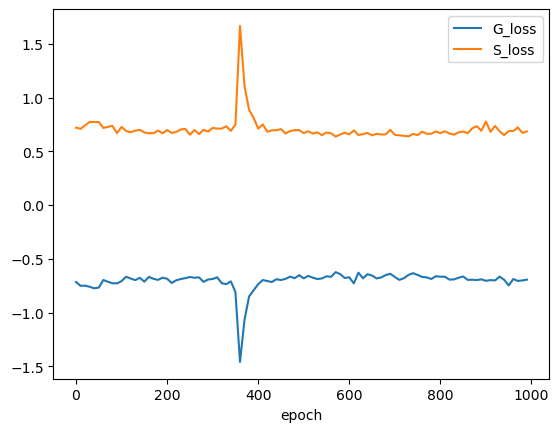

In [24]:
import pandas as pd

df = pd.DataFrame({'epoch': epoch_list, 'G_loss':g_loss_list, 'S_loss':s_loss_list})
df = df.set_index('epoch')
df.plot()

# 모델 성능 평가하기
- 학생 모델은 학습 시, CIFAR-10 데이터를 사용하지 않음
- 과연 얼마나 정확하게 분류 할 수 있을까?

In [21]:
num_corr = 0

student.load_state_dict(torch.load('./models/student.pth', map_location=device))

# 교사 모델이 사용한 학습용 데이터에 대한 학생 모델의 정확도
with torch.no_grad():
    for data, label in tqdm(train_loader):
        data, label = data.to(device), label.to(device)
        
        output = student(data)
        preds = output.data.max(1)[1]
        corr = preds.eq(label).sum().item()
        num_corr += corr
        
    print(f'Acc : {num_corr/len(test_data)}')

100%|████████████████████████████████████████| 313/313 [00:02<00:00, 137.94it/s]

Acc : 0.1196


In [ ]:
# 검증용 데이터에 대한 학생 모델의 정확도
with torch.no_grad():
    for data, label in tqdm(test_loader):
        data, label = data.to(device), label.to(device)
        
        output = student(data)
        preds = output.data.max(1)[1]
        corr = preds.eq(label).sum().item()
        num_corr += corr
        
    print(f'Acc : {num_corr/len(test_data)}')

# 학습 마무리

<img src='./figs/15_07.png'>

# 연습문제

<img src='./figs/15_06.png'>